# Catch that asteroid!

First, we need to increase the timeout time to allow the download of data occur properly

In [1]:
from astropy.utils.data import conf
conf.dataurl

'http://data.astropy.org/'

In [2]:
conf.remote_timeout 

10.0

In [3]:
conf.remote_timeout = 10000

Then, we do the rest of the imports.

In [4]:
from astropy import units as u
from astropy.time import Time, TimeDelta
from astropy.coordinates import solar_system_ephemeris
solar_system_ephemeris.set("jpl")

from poliastro.bodies import Sun, Earth, Moon
from poliastro.ephem import Ephem
from poliastro.frames import Planes
from poliastro.twobody import Orbit
from poliastro.plotting import StaticOrbitPlotter
from poliastro.plotting.misc import plot_solar_system
from poliastro.util import time_range

EPOCH = Time("2017-09-01 12:05:50", scale="tdb")
C_FLORENCE = "#000"
C_MOON = "#999"

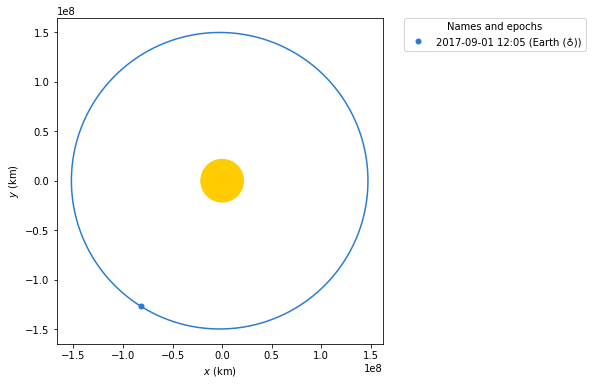

In [5]:
Earth.plot(EPOCH);

Our first option to retrieve the orbit of the Florence asteroid is to use `Orbit.from_sbdb`, which gives us the osculating elements at a certain epoch:

In [6]:
florence_osc = Orbit.from_sbdb("Florence")
florence_osc

1 x 3 AU x 22.1 deg (HeliocentricEclipticIAU76) orbit around Sun (☉) at epoch 2459000.5008007516 (TDB)

However, the epoch of the result is not close to the time of the close approach we are studying:

In [7]:
florence_osc.epoch.iso

'2020-05-31 00:01:09.185'

Therefore, if we `propagate` this orbit to `EPOCH`, the results will be a bit different from the reality. Therefore, we need to find some other means.

Let's use the `Ephem.from_horizons` method as an alternative, sampling over a period of 6 months:

In [8]:
from poliastro.ephem import Ephem

In [9]:
epochs = time_range(
    EPOCH - TimeDelta(3 * 30 * u.day), end=EPOCH + TimeDelta(3 * 30 * u.day)
)

In [10]:
florence = Ephem.from_horizons("Florence", epochs, plane=Planes.EARTH_ECLIPTIC)
florence

Ephemerides at 50 epochs from 2017-06-03 12:05:50.000 (TDB) to 2017-11-30 12:05:50.000 (TDB)

In [11]:
florence.plane

<Planes.EARTH_ECLIPTIC: 'Earth mean Ecliptic and Equinox of epoch (J2000.0)'>

And now, let's compute the distance between Florence and the Earth at that epoch:

In [12]:
earth = Ephem.from_body(Earth, epochs, plane=Planes.EARTH_ECLIPTIC)
earth

Ephemerides at 50 epochs from 2017-06-03 12:05:50.000 (TDB) to 2017-11-30 12:05:50.000 (TDB)

In [13]:
from poliastro.util import norm

In [14]:
min_distance = norm(florence.rv(EPOCH)[0] - earth.rv(EPOCH)[0]) - Earth.R
min_distance.to(u.km)

<Quantity 7060140.8154499 km>

<div class="alert alert-success">This value is consistent with what ESA says! $7\,060\,160$ km</div>

In [15]:
abs((min_distance - 7060160 * u.km) / (7060160 * u.km)).decompose()

<Quantity 2.71729679e-06>

In [16]:
from IPython.display import HTML

HTML(
"""<blockquote class="twitter-tweet" data-lang="en"><p lang="es" dir="ltr">La <a href="https://twitter.com/esa_es">@esa_es</a> ha preparado un resumen del asteroide <a href="https://twitter.com/hashtag/Florence?src=hash">#Florence</a> 😍 <a href="https://t.co/Sk1lb7Kz0j">pic.twitter.com/Sk1lb7Kz0j</a></p>&mdash; AeroPython (@AeroPython) <a href="https://twitter.com/AeroPython/status/903197147914543105">August 31, 2017</a></blockquote>
<script src="//platform.twitter.com/widgets.js" charset="utf-8"></script>"""
)

And now we can plot!

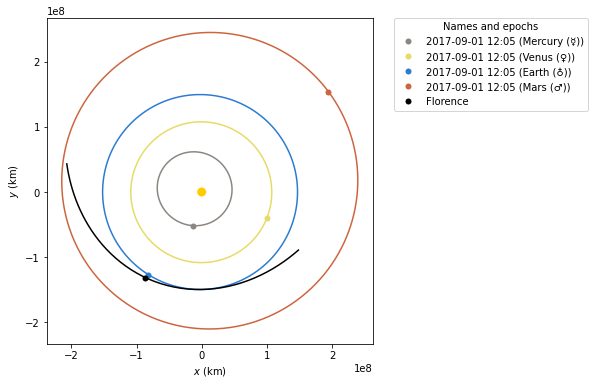

In [17]:
frame = plot_solar_system(outer=False, epoch=EPOCH)
frame.plot_ephem(florence, EPOCH, label="Florence", color=C_FLORENCE);

Finally, we are going to visualize the orbit of Florence with respect to the Earth. For that, we set a narrower time range, and specify that we want to retrieve the ephemerides with respect to our planet:

In [18]:
epochs = time_range(EPOCH - TimeDelta(5 * u.day), end=EPOCH + TimeDelta(5 * u.day))

In [19]:
florence_e = Ephem.from_horizons("Florence", epochs, attractor=Earth)
florence_e

Ephemerides at 50 epochs from 2017-08-27 12:05:50.000 (TDB) to 2017-09-06 12:05:50.000 (TDB)

We now retrieve the ephemerides of the Moon, which are given directly in GCRS:

In [20]:
moon = Ephem.from_body(Moon, epochs, attractor=Earth)
moon

Ephemerides at 50 epochs from 2017-08-27 12:05:50.000 (TDB) to 2017-09-06 12:05:50.000 (TDB)

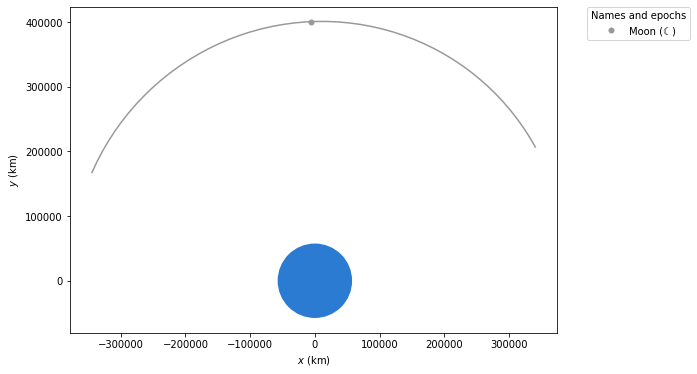

In [21]:
from poliastro.plotting.static import StaticOrbitPlotter

plotter = StaticOrbitPlotter()
plotter.set_attractor(Earth)
plotter.set_body_frame(Moon)
plotter.plot_ephem(moon, EPOCH, label=Moon, color=C_MOON);

And now, the glorious final plot:

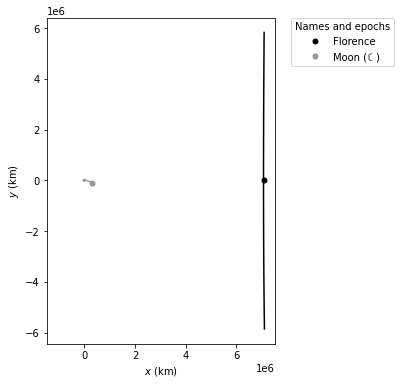

In [22]:
import matplotlib.pyplot as plt

frame = StaticOrbitPlotter()

frame.set_attractor(Earth)
frame.set_orbit_frame(Orbit.from_ephem(Earth, florence_e, EPOCH))

frame.plot_ephem(florence_e, EPOCH, label="Florence", color=C_FLORENCE)
frame.plot_ephem(moon, EPOCH, label=Moon, color=C_MOON);

<div style="text-align: center; font-size: 3em;"><em>Per Python ad astra!</em></div>